In [1]:
# Note to import from .py files, must follow structure
# from <.py filename excluding '.py'> import <class name>
# Optionslam creds: aspringfastlaner Options2018

# Importing necessary models
import smtplib
import pandas as pd
import numpy as np
import datetime as dt
import pandas.stats.moments as st
from helpers import *
import time
%matplotlib inline

# '''
# Calculate the Black-Scholes implied volatility.

# Parameters:	
# price (float) – the Black-Scholes option price
# S (float) – underlying asset price
# K (float) – strike price
# t (float) – time to expiration in years
# r (float) – risk-free interest rate
# flag (str) – ‘c’ or ‘p’ for call or put.
# >>> S = 100
# >>> K = 100
# >>> sigma = .2
# >>> r = .01
# >>> flag = 'c'
# >>> t = .5
# >>> price = black_scholes(flag, S, K, t, r, sigma)
# >>> iv = implied_volatility(price, S, K, t, r, flag)
# '''

# Alpha Vantage API Key
# 5HZEUI5AFJB06BUK

# ts = TimeSeries(key='5HZEUI5AFJB06BUK', output_format='pandas')
# data, meta_data = ts.get_intraday(symbol='MSFT',interval='1min', outputsize='full')
# data['close'].plot()
# plt.title('Intraday Times Series for the MSFT stock (1 min)')
# For intraday
# https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=MSFT&interval=1min&apikey=d5HZEUI5AFJB06BUK&datatype=csv

# For daily
# https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&apikey=5HZEUI5AFJB06BUK&datatype=csv

# Allocate Smartly Checking

In [2]:
# Short Call Assignment Price - 287.5

portfolio_value = 50000

as_lst = ['DBC','IEF','IWM','QQQ','SPY','VGK','VNQ']
as_wgt = [0.028, 0.333, 0.028, 0.028, 0.528, 0.028, 0.028]

as_df = pd.DataFrame({'Allocation': as_wgt}, index = as_lst)
curr_spot = curr_batch_quotes(as_lst)
as_df = pd.concat([as_df,curr_spot[['price']]], axis = 1)

as_df['Market Value'] = portfolio_value*as_df.Allocation
as_df['Holdings'] = np.round(as_df['Market Value']/as_df.price,0)

as_df

,Allocation,price,Market Value,Holdings
symbol,,,,
DBC,0.028,17.265,1400.0,81.0
IEF,0.333,102.305,16650.0,163.0
IWM,0.028,172.420,1400.0,8.0
QQQ,0.028,186.510,1400.0,8.0
SPY,0.528,291.470,26400.0,91.0
VGK,0.028,57.355,1400.0,24.0
VNQ,0.028,84.275,1400.0,17.0


## Checking market correlations

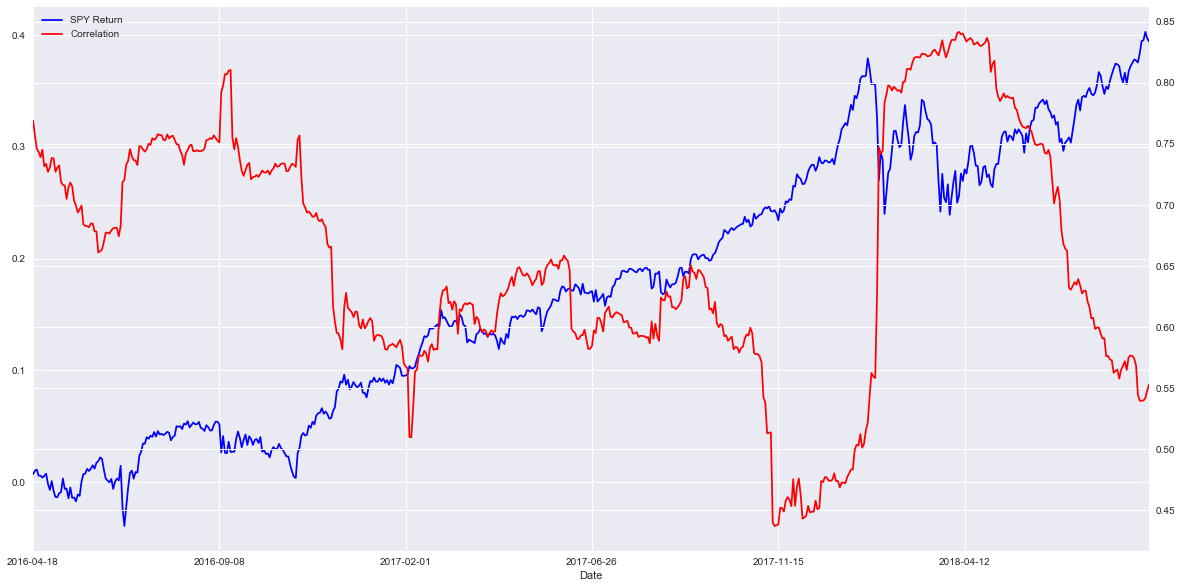

In [2]:
rolling_window = 60
plot_window = 600

corr_df = check_mkt_corr(rolling_window, plot_window)

In [3]:
corr_df.tail()

,XLRE,XLV,XLI,XLB,XLK,XLP,XLU,XLF,XLY,XLE,Avg_Corr,SPY_cum
2018-08-27,0.315699,0.833867,0.751501,0.742790,0.852091,0.244215,-0.237872,0.618503,0.837690,0.441040,0.539952,0.394648
2018-08-28,0.297347,0.834034,0.758474,0.740088,0.850209,0.233576,-0.226062,0.617846,0.838791,0.455685,0.539999,0.395322
2018-08-29,0.291165,0.839102,0.754003,0.748523,0.853342,0.232721,-0.214012,0.613475,0.843336,0.460076,0.542173,0.402830
2018-08-30,0.300512,0.831627,0.753405,0.742338,0.854492,0.246653,-0.146217,0.600991,0.841278,0.458334,0.548341,0.397151
2018-08-31,0.296758,0.832709,0.755910,0.742928,0.859802,0.256101,-0.131114,0.604556,0.839282,0.475464,0.553240,0.394114


# Earnings Checking

In [25]:
start_time = time.time()

# earnings_lst = []
# for earn_date in [dt.datetime(2018,8,13),dt.datetime(2018,8,14)]:
#     try:
#         curr_earnings = yahoo_earnings(earn_date)
#         earnings_lst.append(curr_earnings)
#     except:
#         continue
# earnings = pd.concat(earnings_lst,axis = 0)
earnings = pd.read_csv('earnings.csv', index_col = 0)[['Earnings Date','Implied Move']]
tick_lst = earnings.index.tolist()
vols = current_volatility(tick_lst, roll = 22)
earnings_df = earnings.drop_duplicates().join(vols, how='right').drop_duplicates()
earnings_df['Lower Bound'] = earnings_df['close']*(1 - earnings_df['Implied Move']/100)
earnings_df['Upper Bound'] = earnings_df['close']*(1 + earnings_df['Implied Move']/100)
print("--- %s seconds ---" % (time.time() - start_time))

earnings_df.sort_values('close',ascending = False).dropna()[earnings_df['close'] >= 30]

No Table
No Table
--- 283.97310733795166 seconds ---


C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,Earnings Date,Implied Move,daily_ann,intra_ann,ovrnt_ann,close,daily_dollar_vol,Lower Bound,Upper Bound
NVDA,"Aug. 16, 2018 AC",16.12,0.188288,0.403536,0.128067,259.3400,3.072963,217.534392,301.145608
DE,"Aug. 17, 2018 BO",10.88,0.320030,0.467754,0.149042,137.3100,2.735711,122.370672,152.249328
DDS,"Aug. 16, 2018 AC",7.85,0.777549,1.253788,0.257413,70.9250,4.064440,65.357388,76.492612
CRMT,"Aug. 16, 2018 AC",5.22,0.187202,0.339960,0.077972,66.3750,0.765930,62.910225,69.839775
ATGE,"Aug. 16, 2018 AC",4.53,0.126282,0.264089,0.059121,56.1750,0.445880,53.630272,58.719727
JWN,"Aug. 16, 2018 AC",3.73,0.337296,0.550294,0.108755,52.0100,1.101903,50.070027,53.949973
AMAT,"Aug. 16, 2018 AC",2.52,0.219416,0.320004,0.218536,47.6719,0.656678,46.470568,48.873232
GGAL,"Aug. 16, 2018 AC",1.65,0.475831,0.843482,0.167808,31.2400,0.943599,30.724540,31.755460


In [65]:
start_time = time.time()

focus = ['DE','AMAT']
focus_vol = current_volatility(focus, roll = 22)
focus_names = focus_vol.join(earnings_df[['Implied Move', 'Earnings Date']])

focus_names['Lower Bound'] = focus_names['close']*(1 - focus_names['Implied Move']/100)
focus_names['Upper Bound'] = focus_names['close']*(1 + focus_names['Implied Move']/100)

print("--- %s seconds ---" % (time.time() - start_time))
focus_names

--- 2.2111594676971436 seconds ---


,daily_ann,intra_ann,ovrnt_ann,close,daily_dollar_vol,Implied Move,Earnings Date,Lower Bound,Upper Bound
DE,0.318428,0.468335,0.149042,136.84,2.722020,10.88,"Aug. 17, 2018 BO",121.951808,151.728192
AMAT,0.219312,0.326094,0.218536,47.48,0.656368,2.52,"Aug. 16, 2018 AC",46.283504,48.676496


In [75]:
'''

'''
long_names = ['NVDA','JWN']

print(earnings_df[earnings_df.index.isin(long_names)])

while len(long_names) > 0:
    for hist_name in long_names:

        #hist_name = 'BZUN'
        try:
            print(past_earnings(hist_name))
            print(earnings_history(hist_name))
            long_names.remove(hist_name)
        except:
            continue


         Earnings Date  Implied Move  daily_ann  intra_ann  ovrnt_ann   close  \
JWN   Aug. 16, 2018 AC          3.73   0.337296   0.550294   0.108755   52.01   
NVDA  Aug. 16, 2018 AC         16.12   0.188288   0.403536   0.128067  259.34   

      daily_dollar_vol  Lower Bound  Upper Bound  
JWN           1.101903    50.070027    53.949973  
NVDA          3.072963   217.534392   301.145608  
              open   close      NVDA
timestamp                           
2018-05-11  252.78  254.53 -0.021763
2018-02-09  238.25  232.08  0.064791
2017-11-10  213.08  216.14  0.051357
2017-08-11  157.14  155.96 -0.054769
2017-05-10  114.29  121.29  0.164038
2017-02-10  119.93  113.62 -0.024001
2016-11-11   79.51   87.97  0.260876
2016-08-12   61.90   63.04  0.054437
2016-05-13   39.19   40.98  0.141582
[                Current Qtr Next Qtr Current Year Next Year
No. of Analysts          21       20           25        25
Avg. Estimate          1.66     1.82         7.24      7.92
Low Estimate   

In [76]:
earnings_longs(['NVDA','JWN'], 1)

C:\Users\Fang\Anaconda3\lib\site-packages\py_vollib\ref_python\black_scholes_merton\__init__.py:87: RuntimeWarning:

divide by zero encountered in double_scalars

C:\Users\Fang\Anaconda3\lib\site-packages\py_vollib\black_scholes_merton\greeks\analytical.py:210: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Fang\Anaconda3\lib\site-packages\py_vollib\black_scholes_merton\greeks\analytical.py:153: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Fang\Desktop\Python Trading\SPX Option Backtester\SPX Put Selling\Live Data Pulling\Options Pulling\helpers.py:819: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Strike,DTE,Type,IV,Vol,Open_Int,Moneyness,Root,Underlying_Price,Last,Bid,Ask,Mid,Delta,Gamma,Theta,Vega,HV
0,247.5,28,put,0.405890,7.0,150.0,0.041404,NVDA,258.190,6.91,6.90,7.15,7.025,-0.332857,0.012520,-0.188332,0.259856,0.409878
1,250.0,28,put,0.400763,15.0,141.0,0.031721,NVDA,258.190,7.87,7.80,8.00,7.900,-0.364825,0.013114,-0.192309,0.268739,0.409878
2,252.5,28,put,0.401800,10.0,66.0,0.022038,NVDA,258.190,8.05,8.75,9.10,8.925,-0.399140,0.013439,-0.198094,0.276110,0.409878
3,255.0,28,put,0.396368,11.0,176.0,0.012355,NVDA,258.190,10.65,9.80,10.10,9.950,-0.433363,0.013878,-0.199079,0.281287,0.409878
4,257.5,28,put,0.395026,9.0,70.0,0.002672,NVDA,258.190,10.76,10.85,11.30,11.075,-0.468578,0.014079,-0.200592,0.284391,0.409878
5,265.0,28,call,0.408087,71.0,378.0,0.026376,NVDA,258.190,9.00,8.80,9.10,8.950,0.430882,0.013465,-0.204774,0.280984,0.409878
6,267.5,28,call,0.404120,31.0,149.0,0.036059,NVDA,258.190,7.82,7.75,8.05,7.900,0.397111,0.013344,-0.198995,0.275735,0.409878
7,270.0,28,call,0.400824,136.0,59.0,0.045742,NVDA,258.190,6.85,6.80,7.10,6.950,0.364038,0.013102,-0.192224,0.268544,0.409878
8,272.5,28,call,0.398321,9.0,53.0,0.055424,NVDA,258.190,6.22,5.90,6.25,6.075,0.332105,0.012747,-0.184678,0.259623,0.409878
9,275.0,28,call,0.394965,52.0,126.0,0.065107,NVDA,258.190,5.00,5.15,5.45,5.300,0.300760,0.012325,-0.175567,0.248913,0.409878


In [72]:
start_time = time.time()
max_gap = 5
dte_thresh = 5
money_thresh = 0.1
delta_thresh = 0.03
minimum_prem = 0.15
condors_lst = []
putspread_lst = []
callspread_lst = []
bounds_adj = 0.00

for tick in focus_names.index.drop_duplicates().tolist():
    try:
        condors, put_spreads, call_spreads = earnings_condor(tick, max_gap, dte_thresh, money_thresh)
        condors['Ticker'] = tick
        put_spreads['Ticker'] = tick
        call_spreads['Ticker'] = tick
        condors = condors[(abs(condors['Delta']) <= delta_thresh) &
                    (condors['P Short Strike'] <= focus_names.loc[tick]['Lower Bound']*(1 - bounds_adj)) &
                    (condors['C Short Strike'] >= focus_names.loc[tick]['Upper Bound']*(1 + bounds_adj)) &
                    (condors['Premium'] >= minimum_prem)].sort_values('RiskRewardRatio', ascending = False)

        put_spreads = put_spreads[(put_spreads['Short Put Strike'] <= focus_names.loc[tick]['Lower Bound']) &
                                  (put_spreads['put Spread Premium'] >= minimum_prem)].sort_values('RiskRewardRatio', ascending = False)

        call_spreads = call_spreads[(call_spreads['Short call Strike'] >= focus_names.loc[tick]['Upper Bound']) &
                                    (call_spreads['call Spread Premium'] >= minimum_prem)].sort_values('RiskRewardRatio', ascending = False)
        
        condors_lst.append(condors)
        putspread_lst.append(put_spreads)
        callspread_lst.append(call_spreads)
    except:
        continue

earnings_pspreads = pd.concat(putspread_lst).sort_values('RiskRewardRatio', ascending = False)
earnings_cspreads = pd.concat(callspread_lst).sort_values('RiskRewardRatio', ascending = False)
earnings_condors = pd.concat(condors_lst).sort_values('RiskRewardRatio', ascending = False)

print("--- %s seconds ---" % (time.time() - start_time))

prem_thresh = 0.3
rr_thresh = 0.3

filtered_condors = earnings_condors[(earnings_condors['Premium'] >= prem_thresh) &
                                     (earnings_condors['RiskRewardRatio'] >= rr_thresh)]

filtered_pspreads = earnings_pspreads[(earnings_pspreads['put Spread Premium'] >= prem_thresh) &
                                     (earnings_pspreads['RiskRewardRatio'] >= rr_thresh)]

filtered_cspreads = earnings_cspreads[(earnings_cspreads['call Spread Premium'] >= prem_thresh) &
                                     (earnings_cspreads['RiskRewardRatio'] >= rr_thresh)]

filtered_condors

C:\Users\Fang\Anaconda3\lib\site-packages\py_vollib\ref_python\black_scholes_merton\__init__.py:87: RuntimeWarning:

divide by zero encountered in double_scalars

C:\Users\Fang\Anaconda3\lib\site-packages\py_vollib\black_scholes_merton\greeks\analytical.py:210: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Fang\Anaconda3\lib\site-packages\py_vollib\black_scholes_merton\greeks\analytical.py:153: RuntimeWarning:

invalid value encountered in double_scalars



--- 16.114158153533936 seconds ---


,P Short Strike,P Long Strike,C Short Strike,C Long Strike,Premium,Maxloss,Delta,Gamma,Vega,Theta,RiskRewardRatio,Underlying Price,Ticker
919,46.0,45.0,49.0,50.0,0.42,58.0,0.0,NaN,0.0,NaN,0.72,47.47,AMAT
954,46.0,44.5,49.0,50.5,0.58,92.0,0.0,NaN,0.0,NaN,0.63,47.47,AMAT
924,45.5,44.5,49.0,50.0,0.37,63.0,0.0,NaN,0.0,NaN,0.59,47.47,AMAT
1135,46.0,45.0,49.5,50.5,0.36,64.0,0.0,NaN,0.0,NaN,0.56,47.47,AMAT
959,45.5,44.0,49.0,50.5,0.51,99.0,0.0,NaN,0.0,NaN,0.52,47.47,AMAT
989,46.0,44.0,49.0,51.0,0.68,132.0,0.0,NaN,0.0,NaN,0.52,47.47,AMAT
955,46.0,45.0,49.0,50.5,0.51,99.0,0.0,NaN,0.0,NaN,0.52,47.47,AMAT
918,46.0,44.5,49.0,50.0,0.49,101.0,0.0,NaN,0.0,NaN,0.49,47.47,AMAT
928,45.0,44.0,49.0,50.0,0.33,67.0,0.0,NaN,0.0,NaN,0.49,47.47,AMAT
1170,46.0,44.5,49.5,51.0,0.48,102.0,0.0,NaN,0.0,NaN,0.47,47.47,AMAT


# SPX Options Checking

In [ ]:
start_time = time.time()

dte_thresh = 2
money_thresh = 0.02
tick = '^SPX'
deltas_thresh = [-0.5,-0.01]

spx_options = all_options(tick)

spx_filtered_puts = spx_options[(spx_options['DTE'] <= dte_thresh) &
                                (spx_options['Type'] == 'put') &
                                (spx_options['Delta'] >= deltas_thresh[0]) &
                                (spx_options['Delta'] <= deltas_thresh[1])].reset_index()[spx_options.columns].sort_values('Strike',
                                                                                                                ascending = False)

spreads_lst = []
for idx, row in spx_filtered_puts.iterrows():
    if idx == 0:
        break
    
    temp_chains = spx_filtered_puts[spx_filtered_puts['Strike'] < row.Strike][['Strike','Bid','Ask',
                                                                               'Delta','Gamma','Theta','Vega']]
    temp_chains['DTE'] = row.DTE
    temp_chains['Short Strike'] = row.Strike
    temp_chains['Short Bid'] = row.Bid
    temp_chains['Short Ask'] = row.Ask
    
    temp_chains['Premium'] = (temp_chains['Short Bid'] - temp_chains['Ask'])*100
    temp_chains['Total Risk'] = (temp_chains['Strike'] - temp_chains['Short Strike'])*100 + temp_chains['Premium']
    temp_chains['Delta'] = temp_chains['Delta'] - row.Delta
    temp_chains['Gamma'] = temp_chains['Gamma'] - row.Gamma
    temp_chains['Theta'] = temp_chains['Theta'] - row.Theta
    temp_chains['Vega'] = temp_chains['Vega'] - row.Vega
    
    temp_chains = temp_chains[['DTE','Short Strike','Strike','Premium','Delta','Gamma','Theta','Vega','Total Risk']]
    spreads_lst.append(temp_chains)
    
pspreads_df = pd.concat(spreads_lst, axis = 0).reset_index()[temp_chains.columns]
pspreads_df['RRRatio'] = pspreads_df.Premium/(-pspreads_df['Total Risk'])

pspreads_df = pspreads_df.sort_values('RRRatio',ascending = False)

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
drop_pct = 0.1
starting_pct = 0.05
spot = spx_options['Underlying_Price'][0]

spx_filtered_puts = spx_options[(spx_options['DTE'] == dte_thresh) &
                                (spx_options['Type'] == 'put') &
                                (spx_options['Strike'] >= spot*(1 - drop_pct)) &
                                (spx_options['Strike'] < spot*(1 - starting_pct))].reset_index()[spx_options.columns].sort_values('Strike',
                                                                                                                ascending = False)

spx_filtered_puts

In [85]:
spx = all_options('^SPX')

In [100]:
test = spx[(spx['DTE'] == 29) &
    (spx['Moneyness'] <= 0.02)].reset_index()[spx.columns]
test[test.index.isin([1,3,5])]

,Strike,DTE,Type,IV,Vol,Open_Int,Moneyness,Root,Underlying_Price,Last,Bid,Ask,Mid,Delta,Gamma,Theta,Vega
1,2805.0,29,put,0.112619,35.0,254.0,0.019854,SPXW,2861.82,13.6,14.5,14.9,14.70,-0.258575,0.003560,-0.506512,2.609131
3,2810.0,29,put,0.110772,60.0,342.0,0.018107,SPXW,2861.82,14.7,15.3,15.8,15.55,-0.273928,0.003727,-0.512965,2.686439
5,2815.0,29,put,0.108697,133.0,819.0,0.016360,SPXW,2861.82,16.1,16.2,16.7,16.45,-0.289845,0.003903,-0.517240,2.760567
